In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import random
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack  # To combine sparse matrices
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
nltk.download('punkt_tab')
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")
!pip install contractions
import contractions
from textblob import TextBlob

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv('/content/Combined Data.csv', index_col=0)

In [3]:
df.head(10)

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
5,"every break, you must be nervous, like somethi...",Anxiety
6,"I feel scared, anxious, what can I do? And may...",Anxiety
7,Have you ever felt nervous but didn't know why?,Anxiety
8,"I haven't slept well for 2 days, it's like I'm...",Anxiety
9,"I'm really worried, I want to cry.",Anxiety


In [4]:
df.describe()

,statement,status
count,52681,53043
unique,51073,7
top,what do you mean?,Normal
freq,22,16351


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [6]:
df.isna().sum()

,0
statement,362
status,0


In [7]:
df.dropna(inplace = True)
df.isna().sum()

,0
statement,0
status,0


In [8]:
df.status.value_counts()

,count
status,
Normal,16343
Depression,15404
Suicidal,10652
Anxiety,3841
Bipolar,2777
Stress,2587
Personality disorder,1077


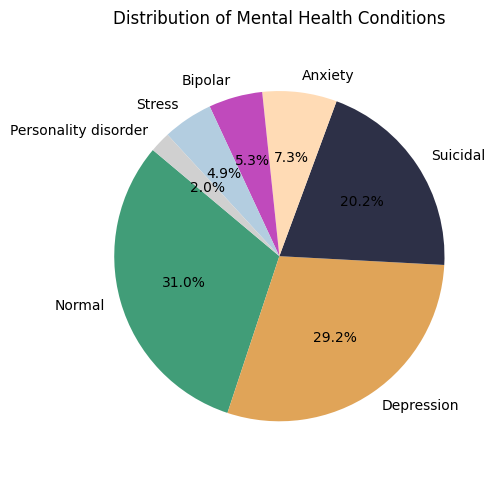

In [9]:
# Count the occurrences of each category
status_counts = df['status'].value_counts()

# Define colors for each category (7 colors)
colors = ['#419D78', '#E0A458', '#2D3047', '#FFDBB5', '#C04ABC', '#B3CDE0', '#D0D0D0']

# Create the pie chart
plt.figure(figsize=(5, 5))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%',
        startangle=140, colors=colors)

plt.title('Distribution of Mental Health Conditions')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

# Display the chart
plt.tight_layout()
plt.show()

In [10]:
# Group by status and get a random statement from each group
random_statements = df.groupby('status')['statement'].apply(lambda x: x.sample(n=1).iloc[0])

# Print the results
for status, statement in random_statements.items():
    print(f"Status: {status}")
    print(f"Statement: {statement}\n")

Status: Anxiety
Statement: Some advice for those of you suffering from hypochondria.... Get professional help before it turns into a more generalized anxiety. Over the course of six years I basically burned myself out on the health anxiety. One disease after another until the point that I stopped caring about any symptoms, imaginary or real, altogether. Unfortunately it's turned into a living hell of generalized daily anxiety with no breaks in between. I thought I had beaten my health anxiety into submission, but in reality it just morphed into a new beast. Now instead of having some relief between imaginary diseases I face an unrelentless onslaught of unreasonable fears. 

Status: Bipolar
Statement: Panic Attacks and Music That Soothes Them I wrote a Medium article about the panic attacks that go along with my Bipolar Disorder and how music seems to help me come down from the panic attacks.

Check it out and tell me what you think:

https://medium.com/@ants000/panic-attacks-and-music-

In [11]:
# Calculate the number of characters and sentences
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Generate descriptive statistics
description = df[['num_of_characters', 'num_of_sentences']].describe()

# Display the descriptive statistics
print(description)

       num_of_characters  num_of_sentences
count       52681.000000      52681.000000
mean          578.713863          6.280215
std           846.269078         10.688388
min             2.000000          1.000000
25%            80.000000          1.000000
50%           317.000000          3.000000
75%           752.000000          8.000000
max         32759.000000       1260.000000


In [12]:
df.head(10)

,statement,status,num_of_characters,num_of_sentences
0,oh my gosh,Anxiety,10,1
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2
3,I've shifted my focus to something else but I'...,Anxiety,61,1
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2
5,"every break, you must be nervous, like somethi...",Anxiety,76,1
6,"I feel scared, anxious, what can I do? And may...",Anxiety,78,2
7,Have you ever felt nervous but didn't know why?,Anxiety,47,1
8,"I haven't slept well for 2 days, it's like I'm...",Anxiety,70,2
9,"I'm really worried, I want to cry.",Anxiety,34,1


In [13]:
df.rename(columns={'statement': 'original_statement'}, inplace=True)

df['statement']=df['original_statement'].str.lower()
df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement
0,oh my gosh,Anxiety,10,1,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,"trouble sleeping, confused mind, restless hear..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,"all wrong, back off dear, forward doubt. stay ..."
3,I've shifted my focus to something else but I'...,Anxiety,61,1,i've shifted my focus to something else but i'...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,"i'm restless and restless, it's been a month n..."


In [14]:
def remove_patterns(text):
    # Handle contractions
    text = contractions.fix(text)
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # Handle spelling correction (optional, computationally expensive)
    # text = str(TextBlob(text).correct())
    return text.strip()


# Apply the function to the 'statement' column
df['statement'] = df['statement'].apply(remove_patterns)
df.head(10)

,original_statement,status,num_of_characters,num_of_sentences,statement
0,oh my gosh,Anxiety,10,1,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,i have shifted my focus to something else but ...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,i am restless and restless it is been a month ...
5,"every break, you must be nervous, like somethi...",Anxiety,76,1,every break you must be nervous like something...
6,"I feel scared, anxious, what can I do? And may...",Anxiety,78,2,i feel scared anxious what can i do and may my...
7,Have you ever felt nervous but didn't know why?,Anxiety,47,1,have you ever felt nervous but did not know why
8,"I haven't slept well for 2 days, it's like I'm...",Anxiety,70,2,i have not slept well for days it is like i am...
9,"I'm really worried, I want to cry.",Anxiety,34,1,i am really worried i want to cry


In [15]:
df['tokens'] = df['statement'].apply(word_tokenize)
df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement,tokens
0,oh my gosh,Anxiety,10,1,oh my gosh,"[oh, my, gosh]"
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ..."
3,I've shifted my focus to something else but I'...,Anxiety,61,1,i have shifted my focus to something else but ...,"[i, have, shifted, my, focus, to, something, e..."
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,i am restless and restless it is been a month ...,"[i, am, restless, and, restless, it, is, been,..."


In [16]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize tokens and convert them to strings
def lemmatize_tokens(tokens):
    return ' '.join(lemmatizer.lemmatize(str(token)) for token in tokens)

# Apply the function to the 'tokens' column
df['tokens_lemmatized'] = df['tokens'].apply(lemmatize_tokens)

df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement,tokens,tokens_lemmatized
0,oh my gosh,Anxiety,10,1,oh my gosh,"[oh, my, gosh]",oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ...",trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ...",all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,i have shifted my focus to something else but ...,"[i, have, shifted, my, focus, to, something, e...",i have shifted my focus to something else but ...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,i am restless and restless it is been a month ...,"[i, am, restless, and, restless, it, is, been,...",i am restless and restless it is been a month ...


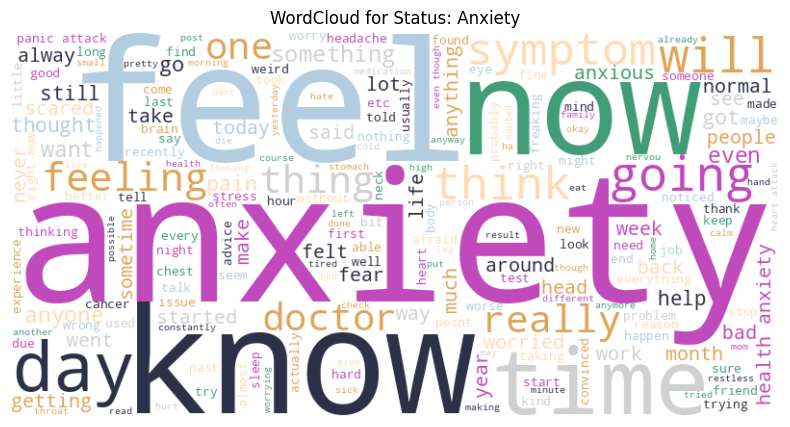

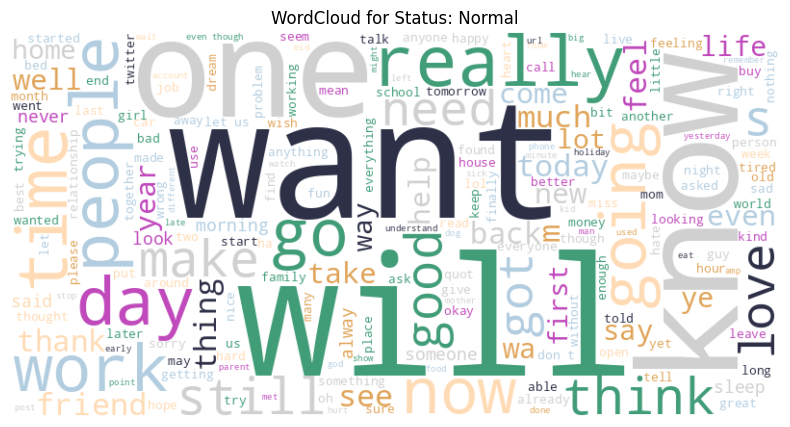

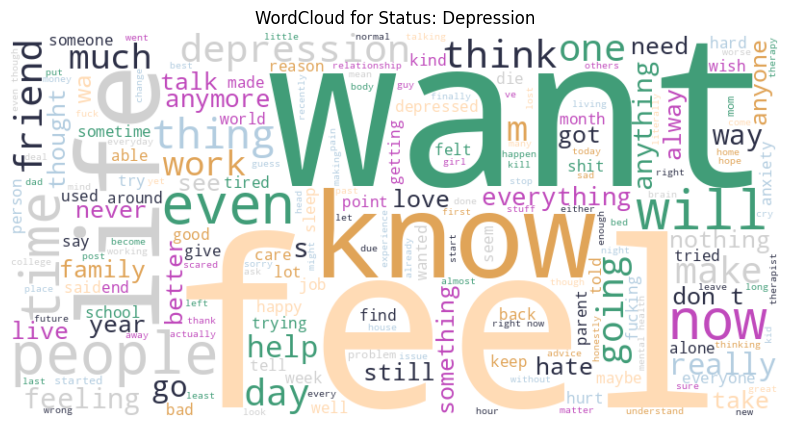

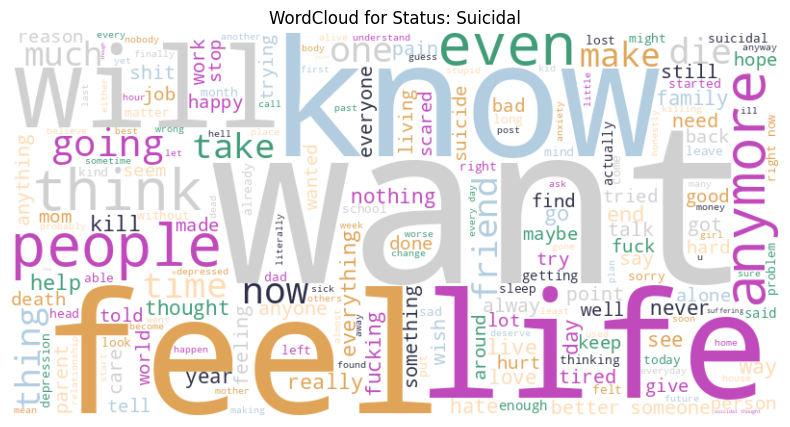

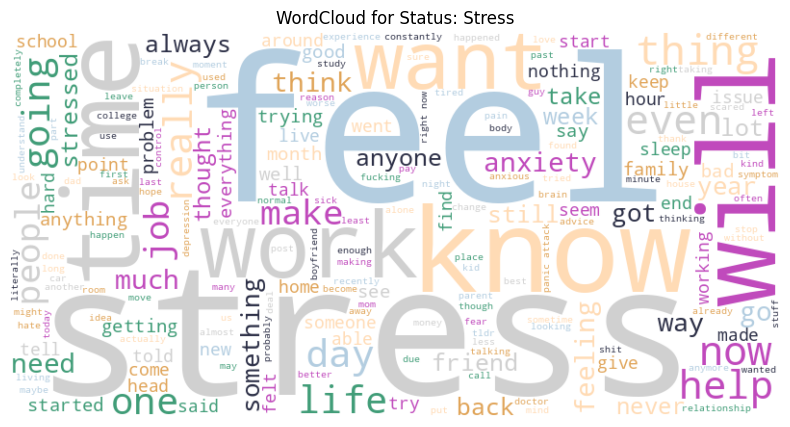

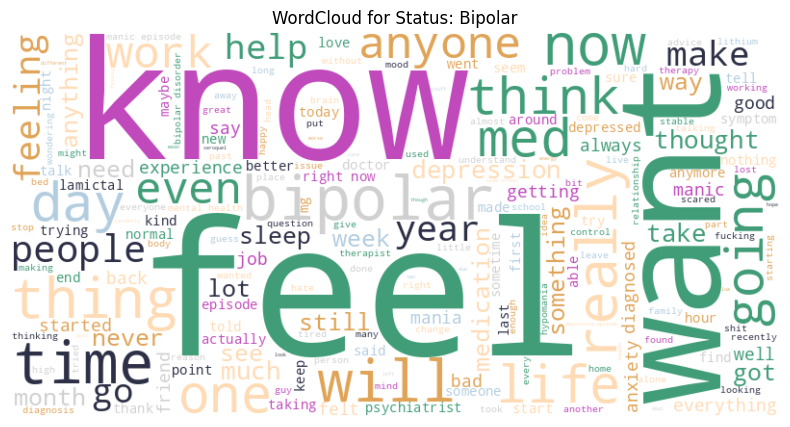

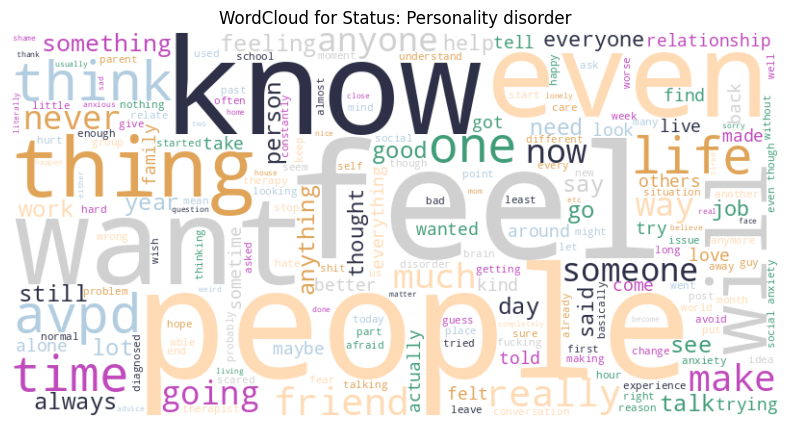

In [17]:
# Get unique categories in 'status'
statuses = df['status'].unique()

# Define a color function
def color_func(word, font_size, position, orientation, random_state=101, **kwargs):
    return random.choice(colors)

# Generate and plot the WordCloud for each category
for status in statuses:
    # Filter the tokens data for the current status
    tokens_data = ' '.join(df[df['status'] == status]['tokens'].dropna().apply(lambda x: ' '.join(x)).tolist())

    # Generate the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(tokens_data)

    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.title(f'WordCloud for Status: {status}')
    plt.show()

In [18]:
X = df[['tokens_lemmatized', 'num_of_characters', 'num_of_sentences']]
y = df['status']

In [19]:
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(y.values)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [21]:
# 1. Initialize TF-IDF Vectorizer and fit/transform on the 'tokens' column
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
X_train_tfidf = vectorizer.fit_transform(X_train['tokens_lemmatized'])
X_test_tfidf = vectorizer.transform(X_test['tokens_lemmatized'])

# 2. Extract numerical features
X_train_num = X_train[['num_of_characters', 'num_of_sentences']].values
X_test_num = X_test[['num_of_characters', 'num_of_sentences']].values

# 3. Combine TF-IDF features with numerical features
X_train_combined = hstack([X_train_tfidf, X_train_num])
X_test_combined = hstack([X_test_tfidf, X_test_num])

print('Number of feature words: ', len(vectorizer.get_feature_names_out()))

Number of feature words:  50000


In [22]:
# Apply Random Over-Sampling on the vectorized data
ros = RandomOverSampler(random_state=101)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_combined, y_train)

In [23]:
X_train_resampled.shape

(91742, 50002)

In [93]:
classifiers = {
    'Bernoulli Naive Bayes': BernoulliNB(alpha=0.01, binarize=0.00),
    'Multinomial Naive Bayes': MultinomialNB(alpha=0.1, fit_prior=False),
    'Decision Tree': DecisionTreeClassifier(max_depth=12, min_samples_split=10, min_samples_leaf=5, class_weight='balanced', random_state=101),
    'XGBoost': XGBClassifier(tree_method='gpu_hist', n_estimators=50, use_label_encoder=False, eval_metric='mlogloss'),
    'Logistic Regression':LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=200, n_jobs=-1),
    'Random Forest': RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_split=10, min_samples_leaf=2, class_weight='balanced', bootstrap=False, n_jobs=-1, random_state=101)
}




For Bernoulli Naive Bayes
Accuracy: 0.6188668501471007
                      precision    recall  f1-score   support

             Anxiety       0.68      0.57      0.62       768
             Bipolar       0.79      0.46      0.58       566
          Depression       0.58      0.48      0.53      3050
              Normal       0.68      0.92      0.78      3237
Personality disorder       0.98      0.23      0.38       202
              Stress       0.42      0.33      0.37       530
            Suicidal       0.52      0.52      0.52      2184

            accuracy                           0.62     10537
           macro avg       0.66      0.50      0.54     10537
        weighted avg       0.62      0.62      0.60     10537



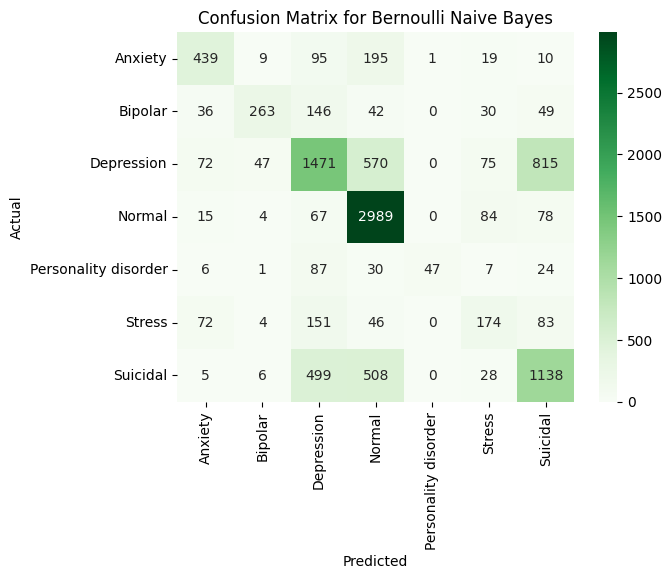



For Multinomial Naive Bayes
Accuracy: 0.6954541140742146
                      precision    recall  f1-score   support

             Anxiety       0.70      0.73      0.71       768
             Bipolar       0.57      0.73      0.64       566
          Depression       0.68      0.54      0.60      3050
              Normal       0.86      0.87      0.87      3237
Personality disorder       0.57      0.52      0.55       202
              Stress       0.49      0.52      0.51       530
            Suicidal       0.59      0.69      0.63      2184

            accuracy                           0.70     10537
           macro avg       0.64      0.66      0.64     10537
        weighted avg       0.70      0.70      0.69     10537



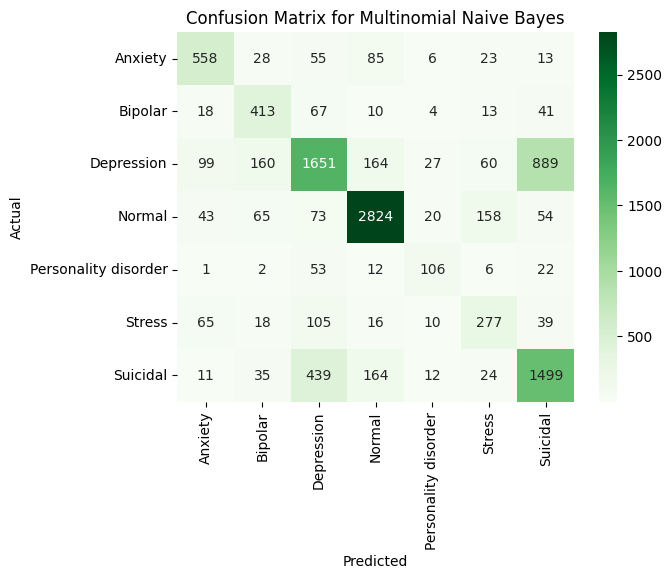



For Decision Tree
Accuracy: 0.6220935750213533
                      precision    recall  f1-score   support

             Anxiety       0.62      0.60      0.61       768
             Bipolar       0.65      0.52      0.58       566
          Depression       0.76      0.39      0.51      3050
              Normal       0.85      0.87      0.86      3237
Personality disorder       0.19      0.53      0.28       202
              Stress       0.38      0.70      0.50       530
            Suicidal       0.45      0.61      0.52      2184

            accuracy                           0.62     10537
           macro avg       0.56      0.60      0.55     10537
        weighted avg       0.68      0.62      0.63     10537



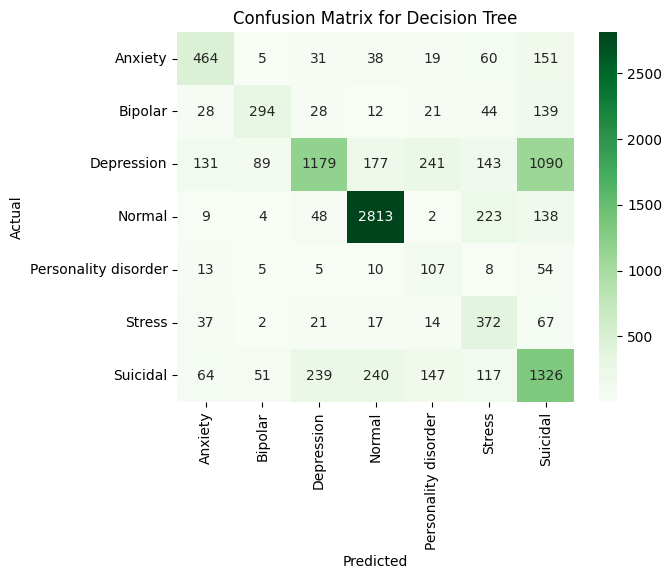



For XGBoost
Accuracy: 0.7523963177374965
                      precision    recall  f1-score   support

             Anxiety       0.77      0.80      0.78       768
             Bipolar       0.73      0.76      0.74       566
          Depression       0.79      0.62      0.69      3050
              Normal       0.90      0.90      0.90      3237
Personality disorder       0.50      0.67      0.57       202
              Stress       0.49      0.82      0.61       530
            Suicidal       0.65      0.69      0.67      2184

            accuracy                           0.75     10537
           macro avg       0.69      0.75      0.71     10537
        weighted avg       0.77      0.75      0.75     10537



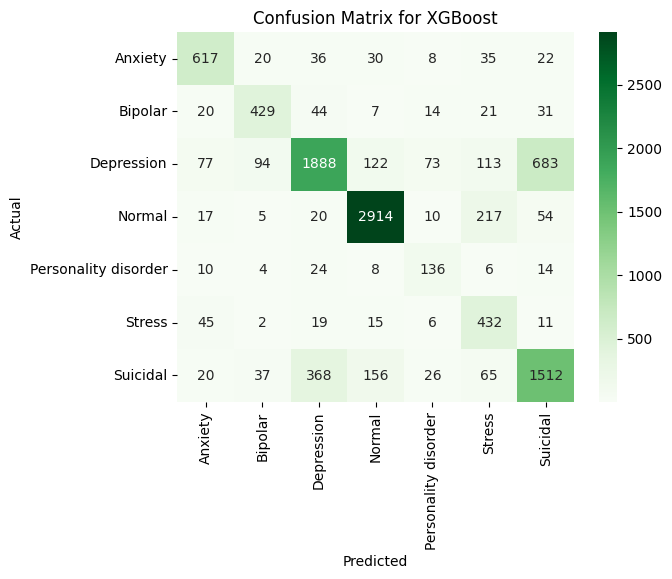



For Logistic Regression
Accuracy: 0.7352187529657398
                      precision    recall  f1-score   support

             Anxiety       0.73      0.80      0.76       768
             Bipolar       0.70      0.79      0.74       566
          Depression       0.78      0.57      0.65      3050
              Normal       0.87      0.91      0.89      3237
Personality disorder       0.44      0.69      0.54       202
              Stress       0.44      0.70      0.54       530
            Suicidal       0.66      0.68      0.67      2184

            accuracy                           0.74     10537
           macro avg       0.66      0.74      0.69     10537
        weighted avg       0.75      0.74      0.73     10537



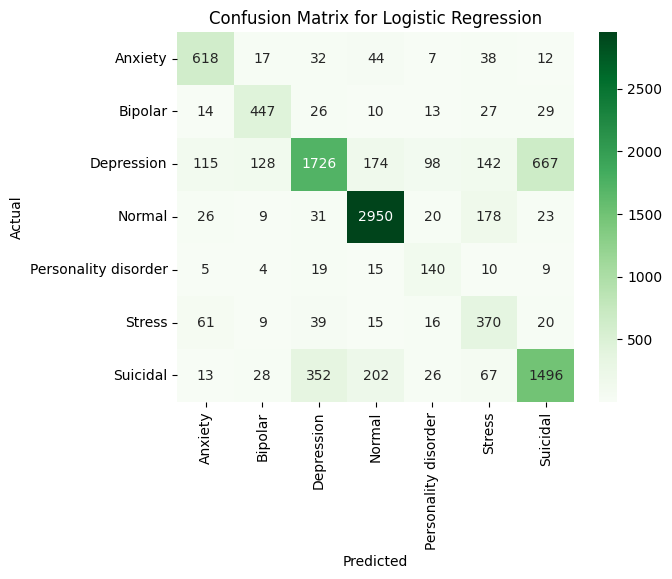



For Random Forest
Accuracy: 0.6409794059030084
                      precision    recall  f1-score   support

             Anxiety       0.73      0.59      0.65       768
             Bipolar       0.59      0.75      0.66       566
          Depression       0.79      0.37      0.50      3050
              Normal       0.69      0.92      0.79      3237
Personality disorder       0.63      0.61      0.62       202
              Stress       0.33      0.68      0.44       530
            Suicidal       0.59      0.59      0.59      2184

            accuracy                           0.64     10537
           macro avg       0.62      0.65      0.61     10537
        weighted avg       0.68      0.64      0.63     10537



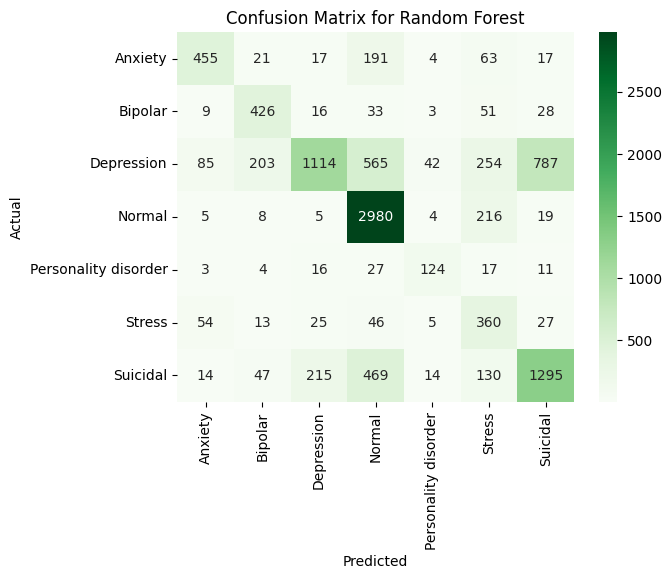

In [94]:
# Initialize a list to store accuracy scores for each classifier
accuracy_scores = []

# Iterate over each classifier and its name in the classifiers dictionary
for name, clf in classifiers.items():
    clf.fit(X_train_resampled, y_train_resampled)
    y_pred = clf.predict(X_test_combined)
    accuracy = accuracy_score(y_test, y_pred)

    print("\n")
    print("For", name)
    print("Accuracy:", accuracy)

    # Compute the confusion matrix for the predictions
    # 'lbl_enc.classes_' provides the class labels for the confusion matrix and classification report
    labels = lbl_enc.classes_
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred, target_names=labels))

    # Plot the confusion matrix using a heatmap
    # Annotate each cell with the numeric value of the confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')  # Label for x-axis
    plt.ylabel('Actual')     # Label for y-axis
    plt.title(f'Confusion Matrix for {name}')  # Title for the heatmap
    plt.show()  # Display the heatmap

    # Append the accuracy score to the list
    accuracy_scores.append(accuracy)

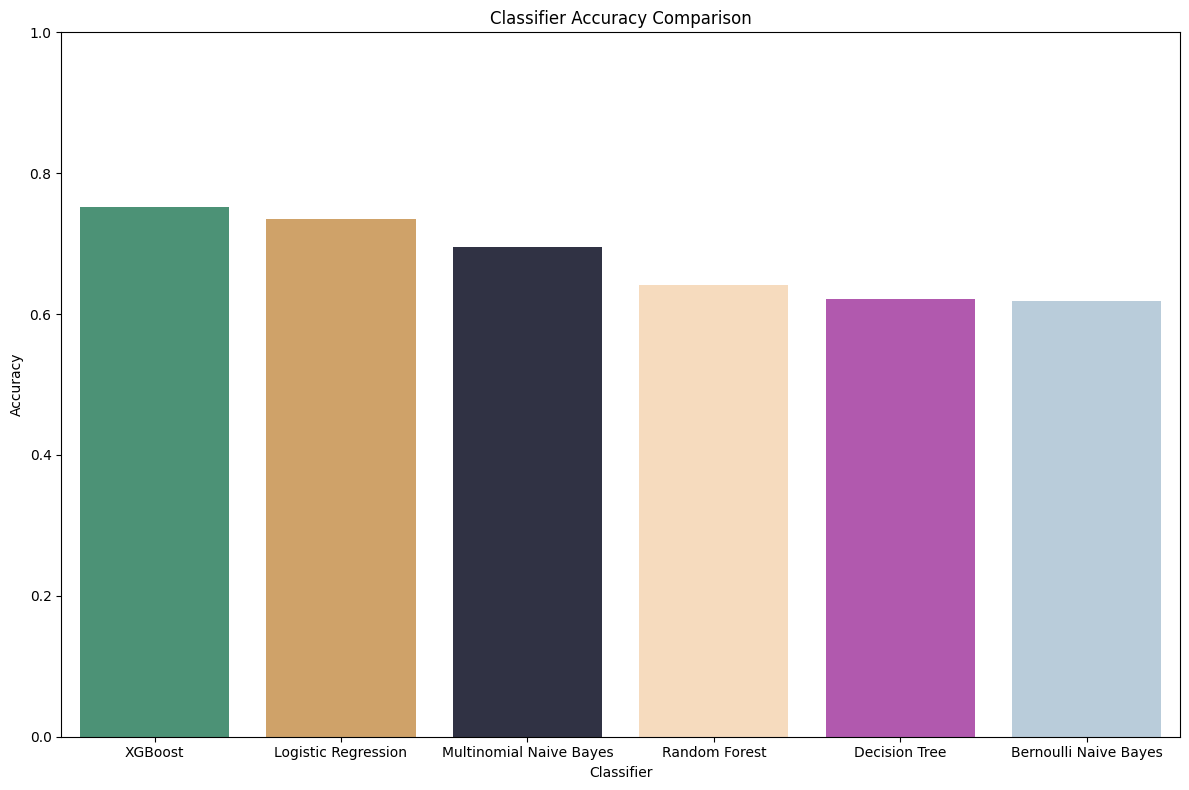

In [96]:
# Create a DataFrame to store classifier names and their corresponding accuracy scores
accuracies_df = pd.DataFrame({'Classifier': classifiers.keys(), 'Accuracy': accuracy_scores}).sort_values('Accuracy', ascending=False)

plt.figure(figsize=(12, 8))
palette = dict(zip(accuracies_df['Classifier'], colors))

# Create a bar plot to visualize the accuracy of each classifier
sns.barplot(x='Classifier', y='Accuracy', data=accuracies_df, palette=palette)

plt.title("Classifier Accuracy Comparison")
plt.ylim(0, 1)

plt.tight_layout()
plt.show()